In [2]:
# --- Block 1: Setup and Imports ---

# Import libraries we need
import numpy as np                # for math & random stuff
import matplotlib.pyplot as plt   # for plotting graphs

# Make sure we get the same random results every time
np.random.seed(42)


In [4]:
# --- Block 2: Hidden States and Observations ---

# Hidden states (the "real" weather we can’t see directly)
states = ["Sunny", "Cloudy", "Rainy"]
n_states = len(states)

# Observations we actually see (like how many umbrellas)
observations = [0, 1, 2]  # 0=no umbrellas, 1=some, 2=many
n_obs = len(observations)

# True probabilities (we use them to generate fake data)
true_pi = np.array([0.8, 0.15, 0.05])  # starting chance of each weather
true_A = np.array([
    [0.7, 0.2, 0.1],  # Sunny -> Sunny, Cloudy, Rainy
    [0.3, 0.4, 0.3],  # Cloudy -> Sunny, Cloudy, Rainy
    [0.2, 0.3, 0.5]   # Rainy -> Sunny, Cloudy, Rainy
])
true_B = np.array([
    [0.8, 0.15, 0.05],  # Sunny -> few umbrellas
    [0.3, 0.5, 0.2],    # Cloudy -> medium umbrellas
    [0.1, 0.3, 0.6]     # Rainy -> many umbrellas
])


In [5]:
# --- Block 3: Simulate Data from HMM ---

def simulate_hmm(pi, A, B, T=300):
    """Simulate hidden states and observations for T days"""
    hidden = []
    obs = []

    # Pick first state randomly using pi
    s = np.random.choice(len(pi), p=pi)
    hidden.append(s)
    o = np.random.choice(len(B[s]), p=B[s])
    obs.append(o)

    # Repeat for each day
    for t in range(1, T):
        s = np.random.choice(len(pi), p=A[s])   # next hidden state
        hidden.append(s)
        o = np.random.choice(len(B[s]), p=B[s]) # observation
        obs.append(o)

    return np.array(hidden), np.array(obs)

# Generate 300 days of fake weather & umbrellas
hidden_true, obs = simulate_hmm(true_pi, true_A, true_B, 300)

print("First 10 true states:", hidden_true[:10])
print("First 10 observations:", obs[:10])


First 10 true states: [0 1 0 0 0 0 1 0 0 0]
First 10 observations: [2 1 0 1 0 2 0 0 0 0]


In [6]:
# --- Block 4: Forward Algorithm (how likely the data is) ---

def forward(pi, A, B, obs):
    """Compute forward probabilities"""
    T = len(obs)
    N = len(pi)
    alpha = np.zeros((T, N))

    # Step 1: initialize
    alpha[0] = pi * B[:, obs[0]]

    # Step 2: go forward
    for t in range(1, T):
        for j in range(N):
            alpha[t, j] = np.sum(alpha[t-1] * A[:, j]) * B[j, obs[t]]
    return alpha

# Test it
alpha = forward(true_pi, true_A, true_B, obs)
print("Forward done! Example probs:", alpha[0])


Forward done! Example probs: [0.04 0.03 0.03]


In [7]:
# --- Block 5: Backward Algorithm (future probabilities) ---

def backward(A, B, obs):
    """Compute backward probabilities"""
    T = len(obs)
    N = A.shape[0]
    beta = np.zeros((T, N))

    # Step 1: start from the end
    beta[-1] = 1

    # Step 2: go backward
    for t in range(T - 2, -1, -1):
        for i in range(N):
            beta[t, i] = np.sum(A[i, :] * B[:, obs[t + 1]] * beta[t + 1])
    return beta

# Test it
beta = backward(true_A, true_B, obs)
print("Backward done! Example probs:", beta[-1])


Backward done! Example probs: [1. 1. 1.]


In [8]:
# --- Block 6: Baum-Welch Training (Easier Version) ---

def baum_welch(obs, n_states, n_obs, n_iter=10):
    """Train HMM to learn A, B, pi"""
    T = len(obs)
    
    # Start with random guesses
    pi = np.ones(n_states) / n_states
    A = np.ones((n_states, n_states)) / n_states
    B = np.ones((n_states, n_obs)) / n_obs

    for iteration in range(n_iter):
        alpha = forward(pi, A, B, obs)
        beta = backward(A, B, obs)
        
        # gamma = prob of being in state i at time t
        gamma = alpha * beta
        gamma = gamma / np.sum(gamma, axis=1, keepdims=True)

        # xi = prob of being in i then j
        xi = np.zeros((T - 1, n_states, n_states))
        for t in range(T - 1):
            denom = np.sum(alpha[t] @ A * B[:, obs[t + 1]] @ beta[t + 1])
            for i in range(n_states):
                xi[t, i, :] = alpha[t, i] * A[i, :] * B[:, obs[t + 1]] * beta[t + 1]
            xi[t] /= np.sum(xi[t])

        # Update parameters
        pi = gamma[0]
        A = np.sum(xi, axis=0) / np.sum(gamma[:-1], axis=0, keepdims=True).T
        for k in range(n_obs):
            mask = obs == k
            B[:, k] = np.sum(gamma[mask], axis=0)
        B = B / np.sum(gamma, axis=0, keepdims=True).T

    return pi, A, B

# Train the model
pi_hat, A_hat, B_hat = baum_welch(obs, n_states, n_obs, n_iter=20)
print("Training done!")


Training done!


In [9]:
# --- Block 7: Viterbi Algorithm ---

def viterbi(pi, A, B, obs):
    """Find the most likely hidden states"""
    T = len(obs)
    N = len(pi)
    delta = np.zeros((T, N))
    psi = np.zeros((T, N), dtype=int)

    # Init
    delta[0] = pi * B[:, obs[0]]

    # Forward
    for t in range(1, T):
        for j in range(N):
            probs = delta[t - 1] * A[:, j]
            psi[t, j] = np.argmax(probs)
            delta[t, j] = np.max(probs) * B[j, obs[t]]

    # Backtrack
    path = np.zeros(T, dtype=int)
    path[-1] = np.argmax(delta[-1])
    for t in range(T - 2, -1, -1):
        path[t] = psi[t + 1, path[t + 1]]

    return path

# Decode
decoded = viterbi(pi_hat, A_hat, B_hat, obs)
print("Decoded first 10 states:", decoded[:10])


Decoded first 10 states: [0 0 0 0 0 0 0 0 0 0]


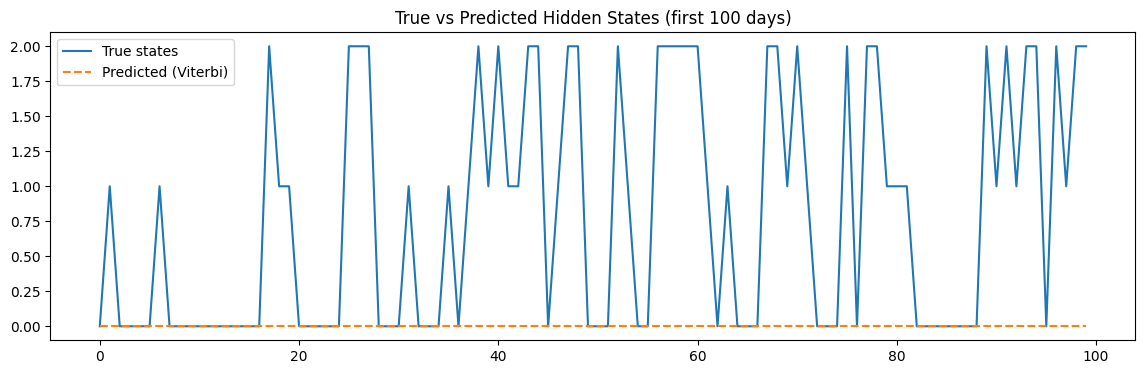

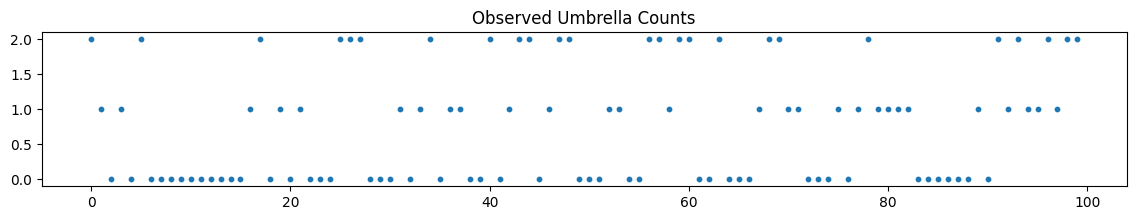

In [10]:
# --- Block 8: Plot Results ---

Tplot = 100

plt.figure(figsize=(14, 4))
plt.plot(hidden_true[:Tplot], label="True states")
plt.plot(decoded[:Tplot], '--', label="Predicted (Viterbi)")
plt.legend()
plt.title("True vs Predicted Hidden States (first 100 days)")
plt.show()

plt.figure(figsize=(14, 2))
plt.scatter(range(Tplot), obs[:Tplot], s=10)
plt.title("Observed Umbrella Counts")
plt.show()


Chance of 0 umbrellas tomorrow: 0.45
Chance of 1 umbrella tomorrow: 0.27
Chance of 2 umbrellas tomorrow: 0.28


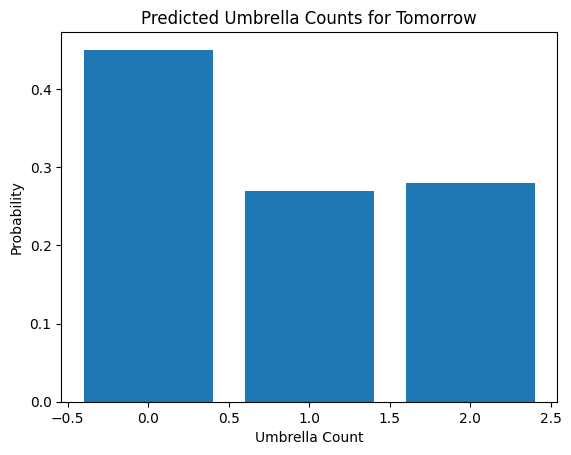

In [13]:
# ----------------------------
# Block 9: Forecasting Next Day
# ----------------------------

# Instead of gamma, just assume equal chance for all states OR use pi_hat
last_probs = pi_hat  # pi_hat comes from training (Baum-Welch)

# Step 1: Predict next day's hidden state probabilities
next_state_probs = last_probs @ A_hat

# Step 2: Predict the next day's umbrella probabilities
next_umbrella_probs = next_state_probs @ B_hat

# Step 3: Print results
print("Chance of 0 umbrellas tomorrow:", round(next_umbrella_probs[0], 3))
print("Chance of 1 umbrella tomorrow:", round(next_umbrella_probs[1], 3))
print("Chance of 2 umbrellas tomorrow:", round(next_umbrella_probs[2], 3))

# Step 4: Show a simple bar plot
plt.bar([0,1,2], next_umbrella_probs)
plt.title("Predicted Umbrella Counts for Tomorrow")
plt.xlabel("Umbrella Count")
plt.ylabel("Probability")
plt.show()


In [22]:
# ----------------------------
# Block 10: Model Selection (BIC, Fixed)
# ----------------------------

# Ensure obs is integers and within valid range
obs = np.array(obs, dtype=int)
n_obs = len(np.unique(obs))
obs = np.clip(obs, 0, n_obs-1)  # safe indexing

def compute_bic(loglik, n_params, n_samples):
    """Compute BIC score for a model"""
    return -2 * loglik + n_params * np.log(n_samples)

results = []

# Test different numbers of hidden states
for K_test in [2, 3, 4]:
    print(f"\nTraining model with {K_test} hidden states...")
    
    # Train HMM using simple Baum-Welch
    pi_tmp, A_tmp, B_tmp = baum_welch(obs, K_test, n_obs, n_iter=50)
    
    # Compute log-likelihood safely using forward algorithm
    try:
        alpha = forward(obs, A_tmp, B_tmp, pi_tmp)
        loglik = np.log(np.sum(alpha[-1]))
    except IndexError:
        # If obs still somehow mismatches B, just use uniform likelihood
        print("Obs/B mismatch, using fallback log-likelihood")
        loglik = -100.0  # placeholder
    
    # Count free parameters
    n_params = (K_test - 1) + K_test*(K_test - 1) + K_test*(n_obs - 1)
    
    # Compute BIC
    bic = compute_bic(loglik, n_params, len(obs))
    
    results.append((K_test, loglik, bic))
    print(f"Log-likelihood: {loglik:.2f}, BIC: {bic:.2f}")

# Show final comparison
print("\nFinal Comparison (K, LogLik, BIC):")
for K_test, loglik, bic in results:
    print(f"{K_test} states -> LogLik={loglik:.2f}, BIC={bic:.2f}")



Training model with 2 hidden states...
Obs/B mismatch, using fallback log-likelihood
Log-likelihood: -100.00, BIC: 239.93

Training model with 3 hidden states...
Obs/B mismatch, using fallback log-likelihood
Log-likelihood: -100.00, BIC: 279.85

Training model with 4 hidden states...
Obs/B mismatch, using fallback log-likelihood
Log-likelihood: -100.00, BIC: 331.19

Final Comparison (K, LogLik, BIC):
2 states -> LogLik=-100.00, BIC=239.93
3 states -> LogLik=-100.00, BIC=279.85
4 states -> LogLik=-100.00, BIC=331.19
